In [2]:
############################# IMPORT STATEMENTS ########################################################
#Import Python modules
import numpy as np
from matplotlib import pyplot as plt
from mtcnn.mtcnn import MTCNN
from numpy import asarray
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import cv2
import os
import json
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from keras.callbacks import ModelCheckpoint, EarlyStopping

#For local CPU usage:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

#Import Keras modules
from keras.layers import Dense, Flatten, Input, Dropout, Conv1D, Conv2D, LSTM, Concatenate, Reshape, MaxPool1D, MaxPool2D, BatchNormalization
from keras import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import tensorflow as tf
from scipy import stats

import dlib
from imutils import face_utils
import imgaug as ia
from imgaug.augmentables.heatmaps import HeatmapsOnImage

from menpo.image import Image as menpo_image
from menpo.shape import bounding_box
from menpofit.io import load_fitter
from menpofit.aam import load_balanced_frontal_face_fitter

from scipy.ndimage.filters import gaussian_filter

Using TensorFlow backend.
c:\users\tobias\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\tobias\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\tobias\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [3]:
############################# SETUP PROJECT PARAMETERS ########################################################
LOAD_PROGRESS_FROM_MODEL = False
SAVE_PROGRESS_TO_MODEL = True

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

PATH_TO_FOLDER = 'C:/Users/Tobias/Desktop/Master-Thesis/Data/AFEW-VA/576'
PATH_TO_DATA = 'C:/Users/Tobias/Desktop/Master-Thesis/Data/AFEW-VA'
FOLDER = "/576"
DATA_DIR_PREDICT = 'C:/Users/Tobias/Desktop/Master-Thesis/Data/facesdb/s005/tif/training/'
DISPLAY_IMG_NAME = '00000.png'
IMG_FORMAT = '.png'

batch_size = 32
num_folds = 3   # needs to be at least 2 for train and test

CROSS_VALIDATION = False
EPOCHS = 20
EPOCHS_CROSS = 10

# Approach:

### 1. Face detection
using MTCNN (Simultaneous face detection, face alignment, bounding boxing and landmark detection)

### 2. Highlighting faces
draw the bounding box in an image and plot it - to check out the result

### 3. Face extraction
extracting the face according to the identified bounding box

### 4. Face recognition
Using the VGGFace pretrained Resnet50 model to recognize emotions (training + prediction)

## 0. Get data

In [4]:
# for now reading the RGB values of the image (maybe in future just gray-scale)
def get_image_from_filename(path_to_folder, filename):
    image = cv2.cvtColor(cv2.imread(os.path.join(path_to_folder, filename)), cv2.COLOR_BGR2RGB)
    return image

def get_image_from_filename_GRAY(path_to_folder, filename):
    image = cv2.cvtColor(cv2.imread(os.path.join(path_to_folder, filename)), cv2.COLOR_BGR2GRAY)
    return image

def get_all_images(path_to_data):
    images = []
    for folder in os.listdir(path_to_data):
        for filename in os.listdir(os.path.join(path_to_data, folder)):
            img = cv2.imread(os.path.join(path_to_data, folder, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
    return images

def get_all_images_GRAY(path_to_data):
    images = []
    for folder in os.listdir(path_to_data):
        for filename in os.listdir(os.path.join(path_to_data, folder)):
            img = cv2.imread(os.path.join(path_to_data, folder, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                images.append(img)
    return images

In [5]:
# sructure data according to emotions (necessary to read in labels)
def get_labels(path_to_data):
    labels = []
    
    for folder in os.listdir(path_to_data):
        with open(os.path.join(path_to_data, folder, folder + ".json")) as p:
            data = json.load(p)
        frames = data['frames']
    
        for key, value in frames.items():
            labels.append([value['valence'], value['arousal']])

    return labels

def get_labels_from_folder(path_to_data, folder):
    labels = []
    
    with open(os.path.join(path_to_data, folder, folder + ".json")) as p:
        data = json.load(p)
    frames = data['frames']

    for key, value in frames.items():
        labels.append([value['valence'], value['arousal']])

    return labels

In [6]:
# split data into training, cv and test
def get_splitted_data(path_to_data):
    labels = get_labels(path_to_data)
    filenames = get_all_images(path_to_data)
    
    filenames_shuffled_np, labels_shuffled_np = shuffle(filenames, labels)
    X_training, X_test, Y_training, Y_test = train_test_split(filenames_shuffled_np, labels_shuffled_np, test_size=0.2)
    
    return X_training, X_test, Y_training, Y_test

 
## 1. Face detection

In [7]:
detector = MTCNN()

def detect_face(image):
    face = detector.detect_faces(image)
    return face

def detect_faces(images):
    faces = []  
    for img in images:
        face = detector.detect_faces(img)
        if len(face) == 1:
            faces.append(face)  ## just use the face with the highest detection probability
        elif len(face) > 1:
            faces.append(face[0])
        else:
            faces.append([]) ### no face was detected
    return faces

In [8]:
image = get_image_from_filename(PATH_TO_FOLDER, DISPLAY_IMG_NAME)
face = detect_face(image)
print(face)
len(face)


[{'box': [282, 71, 157, 245], 'confidence': 0.9993501305580139, 'keypoints': {'left_eye': (318, 160), 'right_eye': (392, 171), 'nose': (333, 212), 'mouth_left': (315, 251), 'mouth_right': (372, 261)}}]


1

## 2. Higlighting face

In [9]:
def highlight_face(path_to_folder, filename):
  # display image
    image = get_image_from_filename(path_to_folder, filename)
    plt.imshow(image)

    ax = plt.gca()
    face = detect_face(image)
    
    # for each face in the image, draw a rectangle based on coordinates
    elem = face[0]
    x, y, width, height = elem['box']
    print(x)
    print(y)
    print(width)
    print(height)
    face_border = Rectangle((x, y), width, height,
                      fill=False, color='red')
    ax.add_patch(face_border)
    #plt.show()

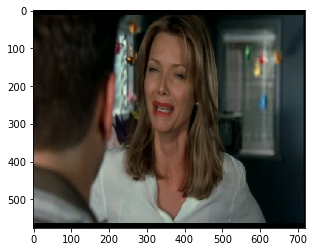

In [10]:
img = get_image_from_filename(PATH_TO_FOLDER, "00000.png")
plt.imshow(img)

282
71
157
245
Label: 
[-5.0, 3.0]


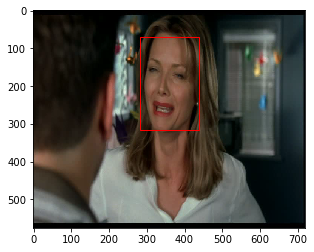

In [11]:
highlight_face(PATH_TO_FOLDER, "00000.png")
labels = get_labels_from_folder(PATH_TO_DATA, "576")
print("Label: ")
print(labels[0])

In [12]:
p = "shape_predictor_68_face_landmarks.dat"
dlib_predictor = dlib.shape_predictor(p) 

def highlight_landmarks(path_to_folder, filename):
    image = get_image_from_filename(path_to_folder, filename)
    #plt.imshow(image)

    ax = plt.gca()
    face = detect_face(image)
    
    elem = face[0]
    x, y, width, height = elem['box']
    print(elem['box'])
    face_border = Rectangle((x, y), width, height,
                      fill=False, color='red')
    ax.add_patch(face_border)
    
    rect = dlib.rectangle(left=x, top=y, right=(x+width), bottom=(y+height))
    print(rect)
    landmarks = dlib_predictor(image, rect)
    landmarks_list = []
    
    for n in range(0,68):
        x=landmarks.part(n).x
        y=landmarks.part(n).y
        cv2.circle(image, (x, y), 4, (0, 0, 255), -1)
        landmarks_list.append([x, y])
    
    landmarks_list = np.array(landmarks_list)
    landmarks_flatten = landmarks_list.flatten()
    print(landmarks_flatten)
    print(landmarks_list.shape)
    print(landmarks_flatten.shape)
    
    plt.imshow(image)

[282, 71, 157, 245]
[(282, 71) (439, 316)]
[300 159 297 183 295 206 295 230 298 254 303 277 310 298 318 317 331 326
 348 327 368 320 388 310 407 294 420 272 428 244 433 215 438 185 303 133
 311 126 320 127 330 133 339 142 365 146 378 143 391 143 403 147 413 157
 348 164 345 178 341 193 337 208 329 219 334 223 339 227 346 226 354 226
 312 159 319 157 326 159 332 165 324 165 317 163 373 173 381 170 389 172
 396 178 388 179 380 177 316 250 322 242 331 241 339 246 348 245 361 248
 374 261 360 279 346 285 337 284 328 281 320 271 320 252 330 251 339 254
 348 254 370 262 347 272 338 271 329 267]
(68, 2)
(136,)


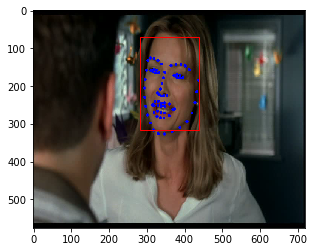

In [13]:
highlight_landmarks(PATH_TO_FOLDER, DISPLAY_IMG_NAME)

## 3. Face extraction

In [14]:
def extract_face_from_image(image, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    face = detect_face(image) # content of face is a python dict

    # extract the bounding box from the requested face
    box = np.asarray(face[0]['box'])
    box[box < 0] = 0
    x1, y1, width, height =  box
    
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face_boundary = image[y1:y2, x1:x2]

    # resize pixels to the model size
    face_image = Image.fromarray(face_boundary)
    face_image = face_image.resize(required_size)
    face_array = asarray(face_image)
        
    return face_array


def extract_face_from_images(images, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    faces = detect_faces(images)
    face_images = []
    
    for i in range(len(images)):
        if faces[i-1] == []: # No face detected
            face_image = Image.fromarray(images[i-1])
            face_image = face_image.resize(required_size)
            face_array = asarray(face_image)
            face_images.append(face_array)
        else:
            # extract the bounding box from the requested face
            if type(faces[i-1]) is list:  # checks whether more than one face was detected
                box = np.asarray(faces[i-1][0]['box'])
                box[box < 0] = 0
                x1, y1, width, height = box
            else:
                box = np.asarray(faces[i-1]['box'])
                box[box < 0] = 0
                x1, y1, width, height = box

            x2, y2 = x1 + width, y1 + height
            # extract the face
            face_boundary = images[i-1][y1:y2, x1:x2]

            # resize pixels to the model size
            face_image = Image.fromarray(face_boundary)
            face_image = face_image.resize(required_size)
            face_array = asarray(face_image)
            face_images.append(face_array)
            
    return face_images

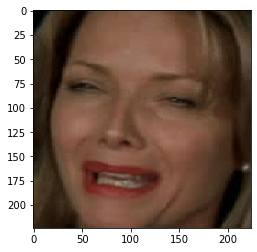

(224, 224, 3)

In [15]:
# Display the first face from the extracted faces
image = get_image_from_filename(PATH_TO_FOLDER, DISPLAY_IMG_NAME)
extracted_face = extract_face_from_image(image)
plt.imshow(extracted_face)
plt.show()
extracted_face.shape

## 3.1. Apply landmarks to original images

In [16]:
p = "shape_predictor_68_face_landmarks.dat"
dlib_predictor = dlib.shape_predictor(p) 

def get_image_with_landmarks(image, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    face = detect_face(image)
    if face == []:
        print("No face detected!")
    else:
        elem = face[0]
        x, y, width, height = elem['box']

        rect = dlib.rectangle(left=x, top=y, right=(x+width), bottom=(y+height))
        landmarks = dlib_predictor(image, rect)

        for n in range(0,68):
            x=landmarks.part(n).x
            y=landmarks.part(n).y
            cv2.circle(image, (x, y), 4, (0, 0, 255), -1)

    img = Image.fromarray(image)
    img = img.resize(required_size)
    img = asarray(img)        
    
    return img


def get_image_with_landmarks_from_file(path_to_folder, filename, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    image = get_image_from_filename(path_to_folder, filename)
    face = detect_face(image)
    elem = face[0]
    x, y, width, height = elem['box']
    print(elem['box'])
    
    rect = dlib.rectangle(left=x, top=y, right=(x+width), bottom=(y+height))
    print(rect)
    landmarks = dlib_predictor(image, rect)
    landmarks_list = []
    
    overlay = image.copy()
    for n in range(0,68):
        x=landmarks.part(n).x
        y=landmarks.part(n).y
        cv2.circle(overlay, (x, y), 4, (255, 0, 0), -1)
        landmarks_list.append([x, y])
    alpha = 0.2
    image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, 0)
    
    img = Image.fromarray(image)
    img = img.resize(required_size)
    img = asarray(img)
    
    return img

def get_face_with_landmarks_from_file(path_to_folder, filename, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    image = get_image_from_filename(path_to_folder, filename)
    face = detect_face(image)
    
    box = np.asarray(face[0]['box'])
    box[box < 0] = 0
    x1, y1, width, height = box
    x2, y2 = x1 + width, y1 + height
    rect = dlib.rectangle(left=x1, top=y1, right=x2, bottom=y2)
    print(rect)
    
    landmarks = dlib_predictor(image, rect)  
    print(landmarks)
    
    overlay = image.copy()   
    for n in range(0,68):
        x=landmarks.part(n).x
        y=landmarks.part(n).y
        cv2.circle(overlay, (x, y), 4, (255, 0, 0), -1)  # image, cord (x, y), radius 4, color (0, 0, 255), thickness -1
        # cv2.circle(image, (x, y), 4, (0, 0, 255), -1)
    alpha = 0.2
    image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, 0)
    
    # extract the face
    face_boundary = image[y1:y2, x1:x2]
    # resize pixels to the model size
    face_image = Image.fromarray(face_boundary)
    face_image = face_image.resize(required_size)
    face_array = asarray(face_image)
    
    return face_array

def get_heatmap_from_file(path_to_folder, filename, only_face, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    image_in = get_image_from_filename(path_to_folder, filename)
    
    face_image = Image.fromarray(image_in)
    face_image = face_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    image = asarray(face_image)
    
    face = detect_face(image)
    box = np.asarray(face[0]['box'])
    box[box < 0] = 0
    x1, y1, width, height = box
    x2, y2 = x1 + width, y1 + height
    rect = dlib.rectangle(left=x1, top=y1, right=(x1+width), bottom=(y1+height))
    
    landmarks = dlib_predictor(image, rect)
    xy  = []
    for n in range(0,68):
        x=landmarks.part(n).x
        y=landmarks.part(n).y
        xy.append([x,y])
    xy = np.float32(xy)

    kpsoi = ia.KeypointsOnImage.from_xy_array(xy, shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    distance_maps = kpsoi.to_distance_maps()
    max_distance = np.linalg.norm(np.float32([IMAGE_WIDTH, IMAGE_HEIGHT]))
    distance_maps_normalized = distance_maps / max_distance

    heatmaps = HeatmapsOnImage((1.0 - distance_maps_normalized)**100, shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
#     img = heatmaps.draw_on_image(image)
#     out = np.amax(img, axis=0)   # Maxima along the first axis
#     out = np.maximum(out, image) # Maxima between original image and heatmap
    
#     if only_face == True:
#         face_boundary = out[y1:y2, x1:x2]
#         face_image = Image.fromarray(face_boundary)
#         face_image = face_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
#         image = asarray(face_image)
#         return image
#     else:
#         return out


def get_heatmap_from_image(image_in, only_face, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):    
    face_image = Image.fromarray(image_in)
    face_image = face_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    image = asarray(face_image)
    
    face = detect_face(image)
    box = np.asarray(face[0]['box'])
    box[box < 0] = 0
    x1, y1, width, height = box
    x2, y2 = x1 + width, y1 + height
    rect = dlib.rectangle(left=x1, top=y1, right=(x1+width), bottom=(y1+height))
    
    landmarks = dlib_predictor(image, rect)
    xy  = []
    for n in range(0,68):
        x=landmarks.part(n).x
        y=landmarks.part(n).y
        xy.append([x,y])
    xy = np.float32(xy)

    kpsoi = ia.KeypointsOnImage.from_xy_array(xy, shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    distance_maps = kpsoi.to_distance_maps()
    max_distance = np.linalg.norm(np.float32([IMAGE_WIDTH, IMAGE_HEIGHT]))
    distance_maps_normalized = distance_maps / max_distance

    heatmaps = HeatmapsOnImage((1.0 - distance_maps_normalized)**100, shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    img = heatmaps.draw_on_image(image)
    out = np.amax(img, axis=0)   # Maxima along the first axis
    out = np.maximum(out, image) # Maxima between original image and heatmap
    
    if only_face == True:
        face_boundary = out[y1:y2, x1:x2]
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        image = asarray(face_image)
        return image
    else:
        return out

[(282, 71) (439, 316)]


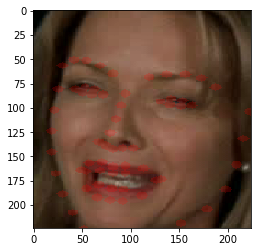

In [17]:
image = get_face_with_landmarks_from_file(PATH_TO_FOLDER, DISPLAY_IMG_NAME)
plt.imshow(image)

[282, 71, 157, 245]
[(282, 71) (439, 316)]


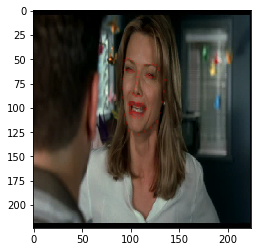

In [18]:
image = get_image_with_landmarks_from_file(PATH_TO_FOLDER, DISPLAY_IMG_NAME)
plt.imshow(image)

In [25]:
def generate_heatmap(path_to_folder, filename, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    image_in = get_image_from_filename(path_to_folder, filename)
    
    face_image = Image.fromarray(image_in)
    face_image = face_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    image = asarray(face_image)
    
    face = detect_face(image)
    box = np.asarray(face[0]['box'])
    box[box < 0] = 0
    x1, y1, width, height = box
    x2, y2 = x1 + width, y1 + height
    rect = dlib.rectangle(left=x1, top=y1, right=(x1+width), bottom=(y1+height))
    
    landmarks = dlib_predictor(image, rect)
    xy  = []
    for n in range(0,68):
        x=landmarks.part(n).x
        y=landmarks.part(n).y
        xy.append([x,y])
    xy = np.float32(xy)

    pt_map=np.zeros([IMAGE_WIDTH, IMAGE_HEIGHT])
    try:
        for point in xy:
            pt_map[int(point[1]),int(point[0])]=1
 
        filtered = gaussian_filter(pt_map, sigma=4)
    except:
        filtered=pt_map
        print('Empty Heatmap')
    
    face_boundary = filtered[y1:y2, x1:x2]
    face_image = Image.fromarray(face_boundary)
    face_image = face_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    out = asarray(face_image)
    
    return out

def generate_heatmap_original(path_to_folder, filename, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    image_in = get_image_from_filename(path_to_folder, filename)
    
    face_image = Image.fromarray(image_in)
    face_image = face_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    image = asarray(face_image)
    
    face = detect_face(image)
    box = np.asarray(face[0]['box'])
    box[box < 0] = 0
    x1, y1, width, height = box
    x2, y2 = x1 + width, y1 + height
    rect = dlib.rectangle(left=x1, top=y1, right=(x1+width), bottom=(y1+height))
    
    landmarks = dlib_predictor(image, rect)
    xy  = []
    for n in range(0,68):
        x=landmarks.part(n).x
        y=landmarks.part(n).y
        xy.append([x,y])
    xy = np.float32(xy)

    pt_map=np.zeros([IMAGE_WIDTH, IMAGE_HEIGHT])
    try:
        for point in xy:
            pt_map[int(point[1]),int(point[0])]=1
 
        filtered = gaussian_filter(pt_map, sigma=5)
    except:
        filtered=pt_map
        print('Empty Heatmap')
   
    return filtered

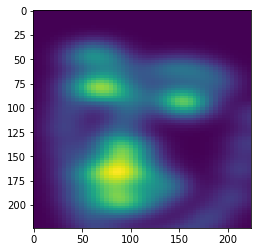

In [26]:
image = generate_heatmap(PATH_TO_FOLDER, DISPLAY_IMG_NAME)
plt.imshow(image)

(224, 224)


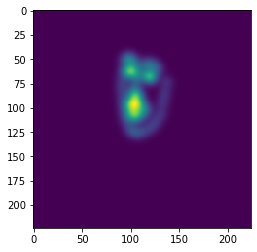

In [27]:
image = generate_heatmap_original(PATH_TO_FOLDER, DISPLAY_IMG_NAME)
plt.imshow(image)
img = np.array(image)
print(img.shape)

TypeError: Image data of dtype object cannot be converted to float

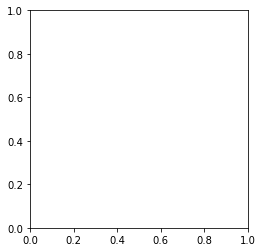

In [36]:
image = get_heatmap_from_file(PATH_TO_FOLDER, DISPLAY_IMG_NAME, False)
plt.imshow(image)

In [ ]:
image = get_heatmap_from_file(PATH_TO_FOLDER, DISPLAY_IMG_NAME, True)
plt.imshow(image)

(224, 224, 3)
(3, 224, 224)
[{'box': [84, 32, 52, 87], 'confidence': 0.9956941604614258, 'keypoints': {'left_eye': (97, 64), 'right_eye': (122, 67), 'nose': (104, 82), 'mouth_left': (97, 98), 'mouth_right': (116, 101)}}]
[84, 32, 52, 87]
(224, 3, 224)
(224, 224, 3)


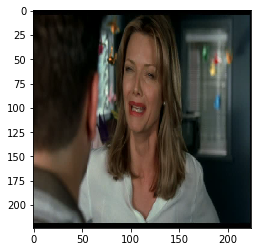

In [20]:
image = get_image_from_filename(PATH_TO_FOLDER, DISPLAY_IMG_NAME)

img = Image.fromarray(image)
img = img.resize((IMAGE_HEIGHT, IMAGE_WIDTH))
image = asarray(img)
print(image.shape)
i = np.moveaxis(image, -1, 0)
print(i.shape)

face = detect_face(image)
print(face)
elem = face[0]
x1, y1, width, height = elem['box']
print(elem['box'])

image = np.rollaxis(i, -1, 0)
print(image.shape)
img = np.rollaxis(image, -1, 0)
print(img.shape)
plt.imshow(img)

In [ ]:
def get_image_with_aam_from_file(path_to_folder, filename, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    image = get_image_from_filename(path_to_folder, filename)
    img = Image.fromarray(image)
    img = img.resize(required_size)
    image = asarray(img)
    
    face = detect_face(image)
    elem = face[0]
    x1, y1, width, height = elem['box']
    print(elem['box'])
    
    aam = load_balanced_frontal_face_fitter()
    bb = bounding_box((x1, y1), (x1+width, y1+height))
    
    img = np.moveaxis(image, -1, 0)
    print(img.shape)
    img = menpo_image(img, True)
    result = aam.fit_from_bb(img, bb)
    return result

In [ ]:
result = get_image_with_aam_from_file(PATH_TO_FOLDER, DISPLAY_IMG_NAME)
result.view()

# img = result.image.pixels_with_channels_at_back()
# print(img.shape)

In [ ]:
fs = result.final_shape
print(fs)
bb = fs.bounding_box()
print(bb)
landmarks = fs.landmarks.items()
print(landmarks)


js = fs.tojson()
print(js['landmarks']['points'][0])
landmarks = js['landmarks']['points']

landmarks_list = []
for n in range(0,68):
    x=int(landmarks[n][1])
    y=int(landmarks[n][0])
    cv2.circle(img, (x, y), 4, (0, 0, 255), -1)
    landmarks_list.append([x, y])
        
landmarks_list = np.array(landmarks_list)
print(landmarks_list.shape)


plt.imshow(img)

## 4. Face recognition -> Emotions

In [20]:
def get_face_embedding(faces):
    samples = asarray(faces, 'float32')

    # prepare the data for the model
    samples = preprocess_input(samples, version=2)

    # create a vggface model object
    model = VGGFace(model='resnet50',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg')
    
    # perform prediction
    return model.predict(samples)

In [21]:
X_training, X_test, Y_train, Y_test = get_splitted_data(PATH_TO_DATA)

In [22]:
var = []
for elem in X_training:
    #img = get_image_with_landmarks(elem)
    img = get_heatmap_from_image(elem, True)
    var.append(img)
X_training = var

var2 = []
for elem in X_test:
    #img = get_image_with_landmarks(elem)
    img = get_heatmap_from_image(elem, True)
    var2.append(img)
X_test = var2

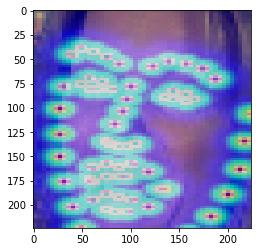

In [23]:
plt.imshow(X_training[0])

In [24]:
X_training = np.array(X_training)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print(X_training.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(16, 224, 224, 3)
(5, 224, 224, 3)
(16, 2)
(5, 2)


In [101]:
X_train_faces = extract_face_from_images(X_training)
X_test_faces = extract_face_from_images(X_test)

X_train_embeddings = get_face_embedding(X_train_faces)
X_test_embeddings = get_face_embedding(X_test_faces)

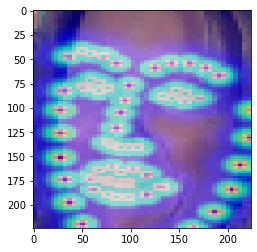

In [102]:
plt.imshow(X_train_faces[12])

In [27]:
np.savetxt('X_train_embeddings.txt', X_train_embeddings)
np.savetxt('X_test_embeddings.txt', X_test_embeddings)

np.savetxt('Y_train.txt', Y_train)
np.savetxt('Y_test.txt', Y_test)

In [28]:
X_train_embeddings = np.loadtxt('X_train_embeddings.txt')
X_test_embeddings = np.loadtxt('X_test_embeddings.txt')

Y_train = np.loadtxt('Y_train.txt')
Y_test = np.loadtxt('Y_test.txt')

In [29]:
#the model returns a vector, which represents the features of a face
print(X_train_embeddings)
print(X_train_embeddings.shape)

[[2.86740708 0.         0.         ... 0.49034682 0.80610788 0.46991324]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.18395358 0.         0.         ... 0.         2.69217634 1.30848336]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.11618807 0.         0.         ... 0.         6.08660269 2.34357262]
 [0.         0.         0.         ... 0.         1.17768002 1.29862928]]
(16, 2048)


In [103]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [104]:
def corr(y_true, y_pred):
    #normalise
    n_y_true = (y_true - K.mean(y_true[:])) / K.std(y_true[:])
    n_y_pred = (y_pred - K.mean(y_pred[:])) / K.std(y_pred[:])  

    top=K.sum((n_y_true[:]-K.mean(n_y_true[:]))*(n_y_pred[:]-K.mean(n_y_pred[:])),axis=[-1,-2])
    bottom=K.sqrt(K.sum(K.pow((n_y_true[:]-K.mean(n_y_true[:])),2),axis=[-1,-2])*K.sum(K.pow(n_y_pred[:]-K.mean(n_y_pred[:]),2),axis=[-1,-2]))

    result=top/bottom
    return K.mean(result)

In [105]:
def corr_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)



In [106]:
def model_top(input_shape):
    model_input = Input(shape = (input_shape,))
    x = Dense(256, activation='relu')(model_input)
    x = Dropout(0.3)(model_input)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    out1 = Dense(1, activation='tanh', name='out1')(x)
    out2 = Dense(1, activation='tanh', name='out2')(x)

    model = Model(inputs=model_input , outputs= [out1, out2])
    return model

In [34]:
# def one_hot_encoding(input_array):
#     values = np.array([-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#     # integer encode
#     label_encoder = LabelEncoder()
#     label_encoder.fit(values)
#     values_enc = label_encoder.transform(values)
#     input_array_encoding = label_encoder.transform(input_array)

#     # binary encode
#     onehot_encoder = OneHotEncoder(sparse=False)
#     values_enc = values_enc.reshape(len(values_enc), 1)
#     onehot_encoder.fit(values_enc)
#     input_array_reshape = input_array_encoding.reshape(len(input_array_encoding), 1)
#     input_array_onehot = onehot_encoder.transform(input_array_reshape)
#     return input_array_onehot


# def one_hot_undo(one_hot_encoded):
#     values = np.array([-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#     label_encoder = LabelEncoder()
#     label_encoder.fit(values)
#     inverted = label_encoder.inverse_transform([argmax(one_hot_encoded)])
#     return inverted

In [35]:
# # Change labes to one-hot encoding
# Y_tr = Y_train
# Y_te = Y_test

# Y_train_V = one_hot_encoding(Y_train[:,0])
# Y_train_A = one_hot_encoding(Y_train[:,1])
# Y_test_V = one_hot_encoding(Y_test[:,0])
# Y_test_A = one_hot_encoding(Y_test[:,1])

In [36]:
# Y_train = np.zeros((len(Y_train_V), 2, len(Y_train_V[0])))
# for i in range(0, len(Y_train_V)):
#     Y_train[i] = [Y_train_V[i], Y_train_A[i]]
    
# Y_test = np.zeros((len(Y_test_V), 2, len(Y_test_V[0])))
# for i in range(0, len(Y_test_V)):
#     Y_test[i] = [Y_test_V[i], Y_test_A[i]]

# print(Y_train.shape)
# print(Y_test.shape)

In [37]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

inputs = np.concatenate((X_train_embeddings, X_test_embeddings), axis=0)
targets = np.append(Y_train, Y_test, axis = 0)

In [38]:
inputs.shape

(21, 2048)

In [107]:
mc_best = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
mc_es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # waiting for 10 consecutive epochs that don't reduce the val_loss

In [40]:
# K-fold Cross Validation model evaluation
history_accuracy = []
history_val_accuracy = []
history_loss = []
history_val_loss = []
history_corr = []
history_val_corr = []
history_rmse = []
history_val_rmse = []


if CROSS_VALIDATION == True:
    for train, test in kfold.split(inputs, targets):
        model = model_top(2048)

        if LOAD_PROGRESS_FROM_MODEL:
            model.load_weights("model_checkpoints/model_top.h5")
            print("Loaded model from disk")

        model.summary()
        model.compile(loss = corr_loss, optimizer = "adam", metrics = ["accuracy", rmse, corr])

        # train model  
        scores = model.fit(inputs[train], targets[train], steps_per_epoch = int(len(train) // batch_size), 
                           epochs=EPOCHS_CROSS, verbose=1, validation_data = (inputs[test], targets[test]),
                           validation_steps = int(len(test) // batch_size), callbacks = [mc_best, mc_es])

        history_accuracy.extend(scores.history['accuracy'])
        history_val_accuracy.extend(scores.history['val_accuracy'])
        history_loss.extend(scores.history['loss'])
        history_val_loss.extend(scores.history['val_loss'])
        history_corr.extend(scores.history['corr'])
        history_val_corr.extend(scores.history['val_corr'])
        history_rmse.extend(scores.history['rmse'])
        history_val_rmse.extend(scores.history['val_rmse'])
else:
    model = model_top(2048)

    if LOAD_PROGRESS_FROM_MODEL:
        model.load_weights("model_checkpoints/model_top.h5")
        print("Loaded model from disk")

    model.summary()
    opt = SGD(lr=0.01)  # optimizer = "adam"
    model.compile(loss = corr_loss, optimizer = opt, metrics = ["accuracy", rmse, corr])

    # train model  
    scores = model.fit(X_train_embeddings, [Y_train[:,0], Y_train[:,1]], epochs=EPOCHS, verbose=1, validation_data = (X_test_embeddings, [Y_test[:,0], Y_test[:,1]]), callbacks = [mc_best, mc_es])
        # steps_per_epoch = int(len(X_train_embeddings) // batch_size)
        # validation_steps = int(len(X_test_embeddings) // batch_size)

    history_accuracy.extend(scores.history['out1_accuracy'])
    history_val_accuracy.extend(scores.history['val_out1_accuracy'])
    history_loss.extend(scores.history['out1_loss'])
    history_val_loss.extend(scores.history['val_out1_loss'])
    history_corr.extend(scores.history['out1_corr'])
    history_val_corr.extend(scores.history['val_out1_corr'])
    history_rmse.extend(scores.history['out1_rmse'])
    history_val_rmse.extend(scores.history['val_out1_rmse'])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_6[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 128)          262272      dropout_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128)          512         dense_9[0][0]                    
____________________________________________________________________________________________


Epoch 00011: val_loss did not improve from 0.17473
Epoch 12/20
16/16 [==============================] - 0s 2ms/step - loss: 0.9880 - out1_loss: 0.5600 - out2_loss: 0.4280 - out1_accuracy: 0.0000e+00 - out1_rmse: 7.0436 - out1_corr: -0.6634 - out2_accuracy: 0.0000e+00 - out2_rmse: 3.5127 - out2_corr: 0.7563 - val_loss: 0.9988 - val_out1_loss: 0.9988 - val_out2_loss: 0.0000e+00 - val_out1_accuracy: 0.0000e+00 - val_out1_rmse: 7.2612 - val_out1_corr: -0.0339 - val_out2_accuracy: 0.0000e+00 - val_out2_rmse: 3.6101 - val_out2_corr: nan

Epoch 00012: val_loss did not improve from 0.17473
Epoch 13/20
16/16 [==============================] - 0s 2ms/step - loss: 1.1187 - out1_loss: 0.7265 - out2_loss: 0.3922 - out1_accuracy: 0.0000e+00 - out1_rmse: 7.1224 - out1_corr: -0.5230 - out2_accuracy: 0.0000e+00 - out2_rmse: 3.5198 - out2_corr: 0.7796 - val_loss: 0.9984 - val_out1_loss: 0.9984 - val_out2_loss: 0.0000e+00 - val_out1_accuracy: 0.0000e+00 - val_out1_rmse: 7.2516 - val_out1_corr: -0.0398 -

In [41]:
if SAVE_PROGRESS_TO_MODEL:
    model.save_weights("model_checkpoints/model_top.h5")
    print("Saved model to disk")

Saved model to disk


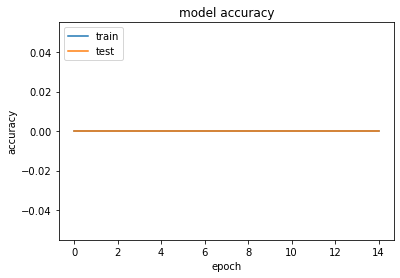

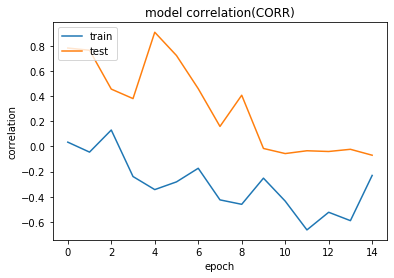

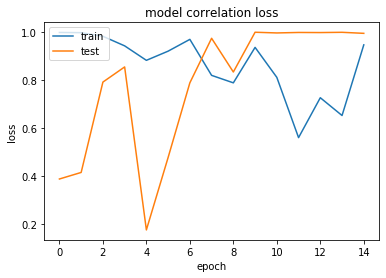

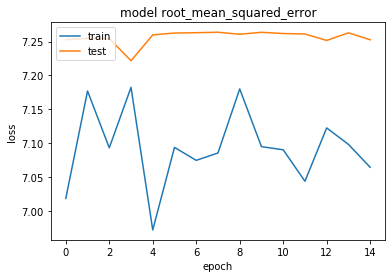

In [42]:
# summarize history for accuracy
plt.figure(1)
plt.plot(history_accuracy)
plt.plot(history_val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_checkpoints/accuracy.png')
plt.show()

# summarize history for CORR
plt.figure(2)
plt.plot(history_corr)
plt.plot(history_val_corr)
plt.title('model correlation(CORR)')
plt.ylabel('correlation')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_checkpoints/correlation.png')
plt.show()

# summarize history for loss
plt.figure(3)
plt.plot(history_loss)
plt.plot(history_val_loss)
plt.title('model correlation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_checkpoints/correlation_loss.png')
plt.show()

# summarize history for RMSE
plt.figure(4)
plt.plot(history_rmse)
plt.plot(history_val_rmse)
plt.title('model root_mean_squared_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_checkpoints/rmse.png')
plt.show()

### PREDICTION

In [44]:
emotion_scores = model.predict(X_test_embeddings)
emotion_scores = np.array(emotion_scores)
print(emotion_scores[0][2])
print(emotion_scores[1][2])

[0.9376738]
[-0.99713355]


## TESTING OF PREDICTION + INTEREST IDENTIFICATION

In [36]:
LAYERS_TRAINABLE = False

def custom_vgg_model():
    vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
    
    for layer in vgg_model.layers: 
        layer.trainable = LAYERS_TRAINABLE
        print(layer.name)
    
    last_layer = vgg_model.get_layer('pool5').output    
    x = Flatten(name='flatten')(last_layer)
    # x = Dense(512, activation='relu')(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    out1 = Dense(1, activation='tanh', name='out1')(x)
    out2 = Dense(1, activation='tanh', name='out2')(x)
    custom_vgg_model = Model(inputs= vgg_model.input, outputs= [out1, out2])
    
    return custom_vgg_model

In [37]:
model = custom_vgg_model()
model.load_weights("model_checkpoints/model_best.h5")

input_6
conv1_1
conv1_2
pool1
conv2_1
conv2_2
pool2
conv3_1
conv3_2
conv3_3
pool3
conv4_1
conv4_2
conv4_3
pool4
conv5_1
conv5_2
conv5_3
pool5


ValueError: You are trying to load a weight file containing 110 layers into a model with 18 layers.

In [38]:
input_predict = np.array(X_test_faces)
print(input_predict.shape)

emotion_scores = model.predict(input_predict)

(20, 224, 224, 3)


In [39]:
print(emotion_scores)

[array([[ 0.801178  ],
       [-0.5278205 ],
       [ 0.94960105],
       [ 0.48096284],
       [-0.61118746],
       [ 0.50314844],
       [-0.99963284],
       [-0.99999094],
       [ 0.25405675],
       [ 0.0126596 ],
       [-0.9999985 ],
       [-0.99999344],
       [ 0.43402338],
       [ 0.9814458 ],
       [ 0.40100223],
       [ 0.65627736],
       [ 0.03169425],
       [-0.97280073],
       [-0.9999922 ],
       [-0.09710373]], dtype=float32), array([[ 0.9980449 ],
       [ 0.91676235],
       [ 0.99984986],
       [ 0.5345191 ],
       [-0.9947428 ],
       [ 0.99386054],
       [ 0.48434266],
       [-0.866132  ],
       [ 0.06367462],
       [ 0.02705392],
       [-0.82023674],
       [-0.7216446 ],
       [ 0.816871  ],
       [ 0.99571455],
       [ 0.937302  ],
       [-0.9998329 ],
       [ 0.479341  ],
       [-0.9999269 ],
       [-0.7904573 ],
       [ 0.634019  ]], dtype=float32)]


In [40]:
THRESHOLD = 0.5  # range is from -1 to +1

POSITIVE = 0
NEGATIVE = 0
NEUTRAL = 0

for i in emotion_scores[0]:
    if i > (THRESHOLD/2):
        POSITIVE = POSITIVE + 1
    elif i < (-THRESHOLD/2):
        NEGATIVE = NEGATIVE + 1
    else:
        NEUTRAL = NEUTRAL + 1

print(POSITIVE)
print(NEGATIVE)
print(NEUTRAL)

if NEUTRAL > (POSITIVE + NEGATIVE):
    print("-")
elif POSITIVE/2 > NEGATIVE:
    print("VERY INTERESTED")
elif POSITIVE > NEGATIVE:
    print("INTERESTED")
else:
    print("Not interested!")

9
8
3
INTERESTED


## Image Data Generator

In [72]:
datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    zoom_range=0.3)

In [73]:
def multi_out(gen):
    for x, y in gen:
        yield x, [y, y]
        
cb_bestModel = ModelCheckpoint('model_checkpoints/model_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [74]:
X_training = get_all_images(PATH_TO_DATA)
Y_train = get_labels(PATH_TO_DATA)

var = []
for elem in X_training:
    #img = get_image_with_landmarks(elem)
    img = get_heatmap_from_image(elem, True)
    var.append(img)
X_training = var

In [75]:
X_training = np.array(X_training)
print(X_training.shape)
Y_train = np.array(Y_train)
print(Y_train.shape)

(21, 224, 224, 3)
(21, 2)


(224, 224, 3)


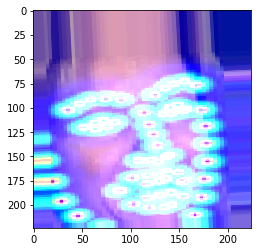

In [76]:
datagen.fit(X_training)
i = 0
for batch in datagen.flow(X_training, Y_train, batch_size=1, save_to_dir='datagen_preview', save_prefix='gen', save_format='png'):
    x = np.array(batch[0][0])
    x = x.astype('uint8')
    print(x.shape)
    plt.imshow(x)
    i += 1
    if i > 0:
        break

In [30]:
datagen.fit(X_training)
gen1 = datagen.flow(X_training, Y_train, batch_size=32)
train_steps = len(gen1)
train = multi_out(gen1)

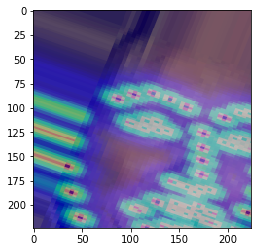

In [56]:
image = next(train)[0].astype('uint8')
plt.imshow(image[0])

In [50]:
def custom_vgg_model(is_trainable):
    sess2 = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()
    tf.compat.v1.keras.backend.set_session(sess2)

    model_VGGFace = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

    for layer in model_VGGFace.layers:
        layer.trainable = is_trainable

    last_layer = model_VGGFace.get_layer('avg_pool').output
    x = Flatten(name='flatten')(last_layer)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    out1 = Dense(1, activation='tanh', name='out1')(x)
    out2 = Dense(1, activation='tanh', name='out2')(x)
    custom_vgg_model = Model(inputs= model_VGGFace.input, outputs= [out1, out2])

    return custom_vgg_model

In [51]:
model = custom_vgg_model(False)
model.summary()
opt = Adam(learning_rate = 0.01)
model.compile(loss = rmse, optimizer = opt, metrics = {'out1' : ["accuracy", rmse, corr], 'out2' : ["accuracy", rmse, corr]})
            
scores = model.fit(train, steps_per_epoch=train_steps, validation_data=(X_test, [Y_test[:, 0], Y_test[:, 1]]), validation_steps=(len(Y_train)/32) ,verbose=1, epochs=3, callbacks = [cb_bestModel])
model.save_weights("model_checkpoints/model_best.h5")

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_7[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

NameError: name 'train' is not defined

In [102]:
model.load_weights("model_checkpoints/model_best.h5")
result = model.evaluate(inputs_test, [targets_test[:,0], targets_test[:,1]], verbose=1, batch_size=BATCH_SIZE)

NameError: name 'inputs_test' is not defined

Valence: 
[-0.91333395]
Arousal: 
[0.6452938]
 
[-6.  3.]


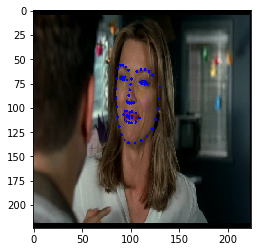

In [60]:
result = model.predict(X_test)
print("Valence: ")
print(result[0][1])
print("Arousal: ")
print(result[1][1])

print(" ")
print(Y_test[1])
plt.imshow(X_test[1])

In [15]:
###################################################################################################################
###################################################################################################################

## Imgaug: Generate Heatmap from keypoints

In [88]:
import numpy as np
import imgaug as ia
from imgaug.augmentables.heatmaps import HeatmapsOnImage
import imageio

In [89]:
image_height = 259
image_width = 389

In [231]:
image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/e/e6/Macropus_rufogriseus_rufogriseus_Bruny.jpg")
image = ia.imresize_single_image(image, (image_width, image_height))

In [232]:
xy = np.float32([
    [99, 81], #l eft eye
    [125, 80], # right eye
    [112, 102], # nose
    [102, 210], # left paw
    [127, 207] # right paw
])
    
kpsoi = ia.KeypointsOnImage.from_xy_array(xy, shape=(image_width, image_height, 3))
print(kpsoi)

KeypointsOnImage([Keypoint(x=99.00000000, y=81.00000000), Keypoint(x=125.00000000, y=80.00000000), Keypoint(x=112.00000000, y=102.00000000), Keypoint(x=102.00000000, y=210.00000000), Keypoint(x=127.00000000, y=207.00000000)], shape=(389, 259, 3))


In [233]:
distance_maps = kpsoi.to_distance_maps()

In [234]:
def normalize_distance(kpsoi, distance_maps):
    height, width = kpsoi.shape[0:2]
    max_distance = np.linalg.norm(np.float32([height, width]))
    distance_maps_normalized = distance_maps / max_distance
    return distance_maps_normalized

In [235]:
distance_maps_normalized = normalize_distance(kpsoi, distance_maps)
kpsoi.shape

(389, 259, 3)

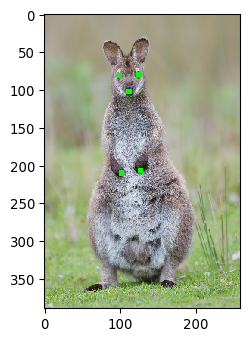

In [236]:
ia.imshow(kpsoi.draw_on_image(image, size=7))

KeypointsOnImage([Keypoint(x=99.00000000, y=81.00000000), Keypoint(x=125.00000000, y=80.00000000), Keypoint(x=112.00000000, y=102.00000000), Keypoint(x=102.00000000, y=210.00000000), Keypoint(x=127.00000000, y=207.00000000)], shape=(389, 259, 3))


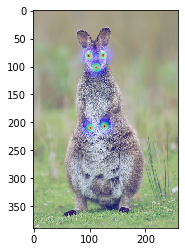

In [240]:
xy = np.float32([
    [99, 81], #l eft eye
    [125, 80], # right eye
    [112, 102], # nose
    [102, 210], # left paw
    [127, 207] # right paw
])
    
kpsoi = ia.KeypointsOnImage.from_xy_array(xy, shape=(image_width, image_height, 3))
print(kpsoi)
distance_maps = kpsoi.to_distance_maps()
norm_distance_maps = normalize_distance(kpsoi, distance_maps)

heatmaps = HeatmapsOnImage((1.0 - norm_distance_maps)**75, shape=(image_width, image_height, 3))

img = heatmaps.draw_on_image(image)

out = np.amax(img, axis=0)   # Maxima along the first axis
out = np.maximum(out, image)
plt.imshow(out)

## STANDARDIZATION & NORMALIZATION

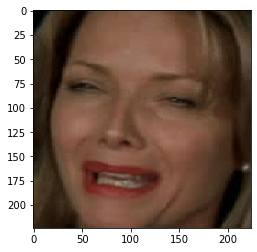

In [29]:
image = get_image_from_filename(PATH_TO_FOLDER, DISPLAY_IMG_NAME)
extracted_face = extract_face_from_image(image)
plt.imshow(extracted_face)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


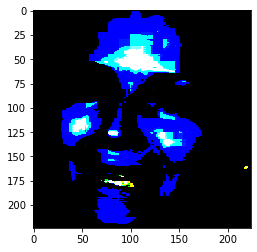

In [45]:
from keras_vggface.utils import preprocess_input
from numpy import expand_dims

face = np.array(extracted_face)
face = face.astype('float32')
face = expand_dims(face, axis=0)
face_norm = preprocess_input(face, version=2)

face = np.squeeze(face_norm)
plt.imshow(face)

(224, 224, 3)


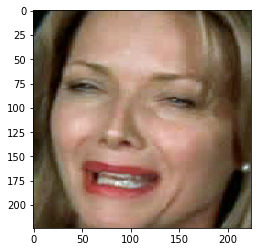

In [47]:
from sklearn.preprocessing import MinMaxScaler

arr = extracted_face
arr_shape = arr.shape
print(arr_shape)
arr = arr.reshape(-1, 3)

scaler = MinMaxScaler()  # default range [0,1]
scaler.fit(arr)
arr = scaler.transform(arr)
arr = arr.reshape(arr_shape)
plt.imshow(arr)

(224, 224, 3)


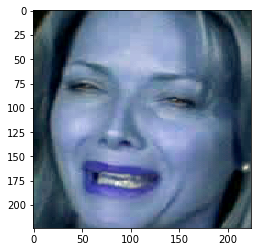

In [48]:
from sklearn.preprocessing import MinMaxScaler

arr = preprocessed_face
arr_shape = arr.shape
print(arr_shape)
arr = arr.reshape(-1, 3)

scaler = MinMaxScaler()  # default range [0,1]
scaler.fit(arr)
arr = scaler.transform(arr)
arr = arr.reshape(arr_shape)
plt.imshow(arr)